Epoch 1, Loss: 0.7527, Val Accuracy: 0.2395
Epoch 2, Loss: 0.7524, Val Accuracy: 0.2395
Epoch 3, Loss: 0.7521, Val Accuracy: 0.2398
Epoch 4, Loss: 0.7517, Val Accuracy: 0.2400
Epoch 5, Loss: 0.7514, Val Accuracy: 0.2401
Epoch 6, Loss: 0.7511, Val Accuracy: 0.2403
Epoch 7, Loss: 0.7507, Val Accuracy: 0.2404
Epoch 8, Loss: 0.7504, Val Accuracy: 0.2406
Epoch 9, Loss: 0.7501, Val Accuracy: 0.2409
Epoch 10, Loss: 0.7497, Val Accuracy: 0.2409
Epoch 11, Loss: 0.7494, Val Accuracy: 0.2409
Epoch 12, Loss: 0.7491, Val Accuracy: 0.2411
Epoch 13, Loss: 0.7487, Val Accuracy: 0.2411
Epoch 14, Loss: 0.7484, Val Accuracy: 0.2412
Epoch 15, Loss: 0.7481, Val Accuracy: 0.2411
Epoch 16, Loss: 0.7477, Val Accuracy: 0.2415
Epoch 17, Loss: 0.7474, Val Accuracy: 0.2414
Epoch 18, Loss: 0.7471, Val Accuracy: 0.2418
Epoch 19, Loss: 0.7467, Val Accuracy: 0.2418
Epoch 20, Loss: 0.7464, Val Accuracy: 0.2423


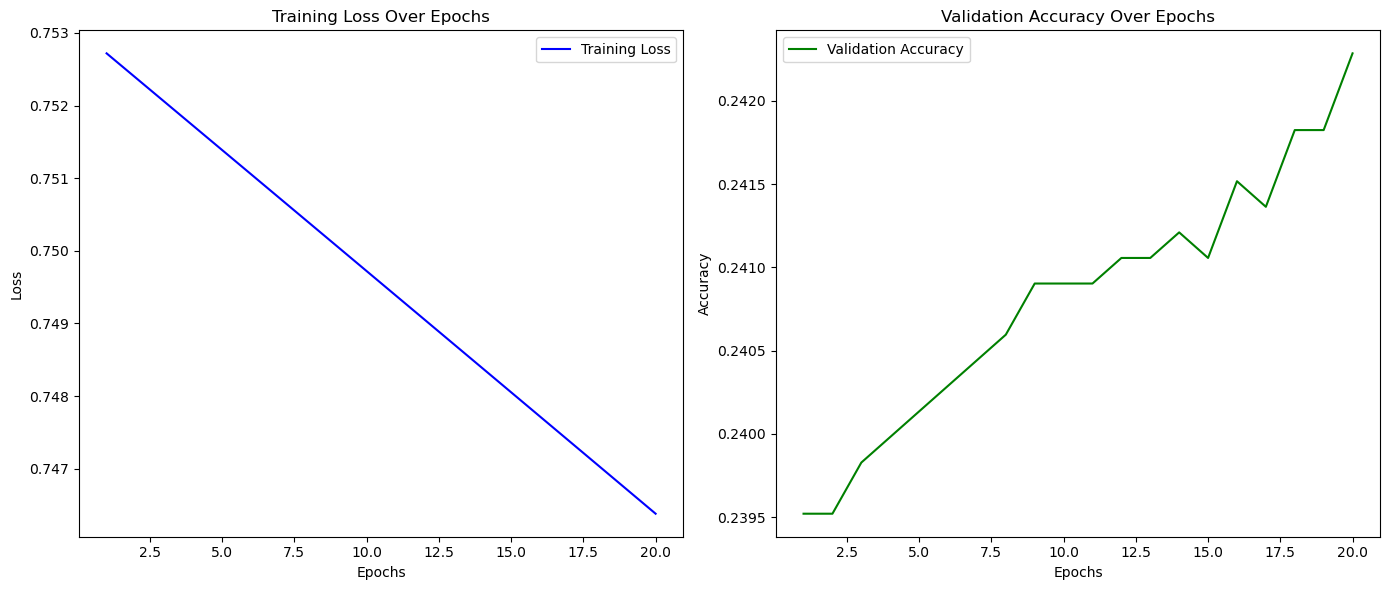

Hybrid Model Accuracy: 0.7588


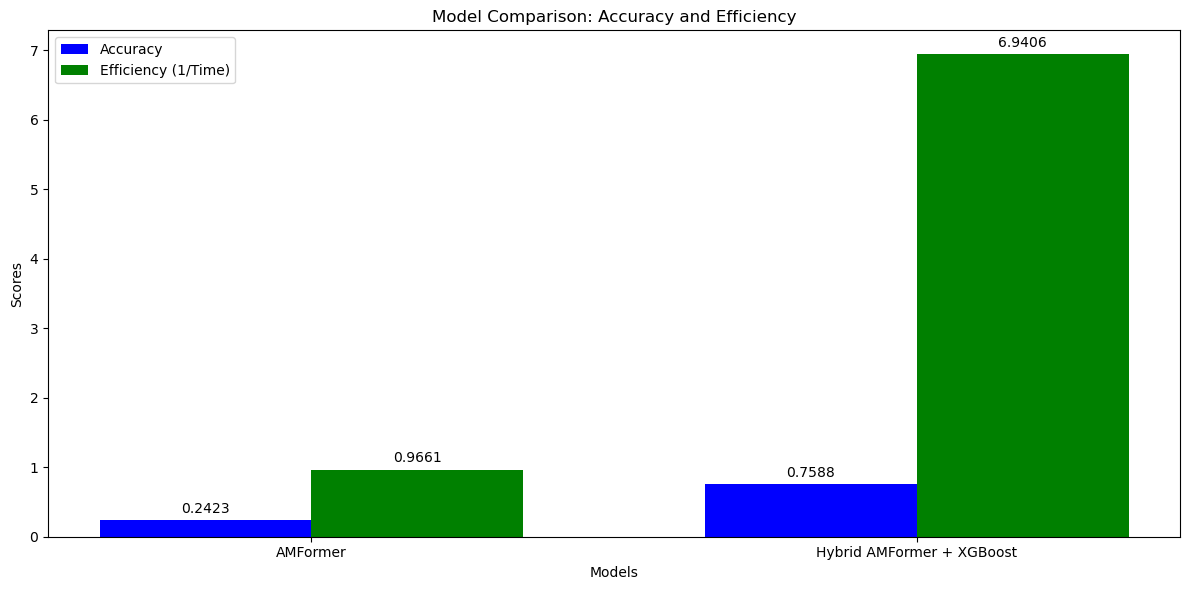

In [3]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Step 1: Load and preprocess the data
def load_data(file_path):
    """Load and preprocess the Adult dataset."""
    data = pd.read_csv(file_path)

    # Encode target variable
    data['income'] = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

    # Encode categorical features
    categorical_features = ['workclass', 'education', 'marital_status', 'occupation',
                            'relationship', 'race', 'sex', 'native_country']
    for col in categorical_features:
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col].astype(str))

    # Separate features and target
    X = data.drop('income', axis=1)
    y = data['income']

    # Normalize numerical features
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)

    return train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define AMFormer with higher-order feature interactions
class AMFormer(nn.Module):
    def __init__(self, input_dim, num_classes=1, interaction_order=3):
        super(AMFormer, self).__init__()
        self.interaction_order = interaction_order
        self.attention_layers = nn.ModuleList([
            nn.Linear(input_dim, input_dim) for _ in range(interaction_order)
        ])
        self.feature_importance_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Softmax(dim=-1)
        )
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        interaction = x
        for layer in self.attention_layers:
            interaction = torch.relu(layer(interaction))  # Handling higher-order interactions
        feature_importance = self.feature_importance_net(x)  # Dynamic feature importance
        weighted_features = x * feature_importance  # Weight features based on importance
        combined = weighted_features + interaction  # Combine weighted features with interactions
        return self.fc(combined)

# Step 3: Training function
def train_model(model, X_train, y_train, X_val, y_val, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    X_train, y_train = torch.tensor(X_train.values).float().to(device), torch.tensor(y_train.values).float().to(device)
    X_val, y_val = torch.tensor(X_val.values).float().to(device), torch.tensor(y_val.values).float().to(device)

    training_losses = []
    validation_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = torch.sigmoid(model(X_val).squeeze())
            val_preds = (val_outputs > 0.5).float()
            val_acc = accuracy_score(y_val.cpu(), val_preds.cpu())
            validation_accuracies.append(val_acc)
            print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, Val Accuracy: {val_acc:.4f}")

    return training_losses, validation_accuracies

# Step 4: Hybrid Model with XGBoost
class HybridModel:
    def __init__(self, amformer, xgb):
        self.amformer = amformer
        self.xgb = xgb

    def train(self, X_train, y_train):
        with torch.no_grad():
            X_transformed = self.amformer(torch.tensor(X_train.values).float()).cpu().numpy()
        self.xgb.fit(X_transformed, y_train)

    def predict(self, X_test):
        with torch.no_grad():
            X_transformed = self.amformer(torch.tensor(X_test.values).float()).cpu().numpy()
        return self.xgb.predict(X_transformed)

# Step 5: Visualization
def plot_metrics(training_losses, validation_accuracies):
    epochs = range(1, len(training_losses) + 1)

    plt.figure(figsize=(14, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_efficiency_and_accuracy(models, accuracies, times):
    x = np.arange(len(models))  # Label locations
    width = 0.35  # Width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width / 2, accuracies, width, label='Accuracy', color='blue')
    bars2 = ax.bar(x + width / 2, 1 / np.array(times), width, label='Efficiency (1/Time)', color='green')

    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison: Accuracy and Efficiency')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Example Workflow
if __name__ == "__main__":
    # Load dataset
    dataset_path = 'adult.csv'  # Use your dataset
    X_train, X_test, y_train, y_test = load_data(dataset_path)

    # Train AMFormer
    amformer = AMFormer(input_dim=X_train.shape[1], num_classes=1, interaction_order=3)
    start_time = time.time()
    training_losses, validation_accuracies = train_model(amformer, X_train, y_train, X_test, y_test, epochs=20)
    amformer_time = time.time() - start_time

    # Plot metrics for AMFormer
    plot_metrics(training_losses, validation_accuracies)

    # Hybrid Model with XGBoost
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    hybrid_model = HybridModel(amformer, xgb_model)
    start_time = time.time()
    hybrid_model.train(X_train, y_train)
    hybrid_time = time.time() - start_time

    hybrid_preds = hybrid_model.predict(X_test)
    hybrid_acc = accuracy_score(y_test, hybrid_preds)
    print(f"Hybrid Model Accuracy: {hybrid_acc:.4f}")

    # Efficiency and accuracy comparison
    models = ["AMFormer", "Hybrid AMFormer + XGBoost"]
    accuracies = [max(validation_accuracies), hybrid_acc]
    times = [amformer_time, hybrid_time]

    plot_efficiency_and_accuracy(models, accuracies, times)


Epoch 1, Loss: 0.6568, Val Accuracy: 0.7583
Epoch 2, Loss: 0.6566, Val Accuracy: 0.7583
Epoch 3, Loss: 0.6565, Val Accuracy: 0.7583
Epoch 4, Loss: 0.6563, Val Accuracy: 0.7583
Epoch 5, Loss: 0.6562, Val Accuracy: 0.7583
Epoch 6, Loss: 0.6560, Val Accuracy: 0.7583
Epoch 7, Loss: 0.6559, Val Accuracy: 0.7583
Epoch 8, Loss: 0.6557, Val Accuracy: 0.7583
Epoch 9, Loss: 0.6555, Val Accuracy: 0.7583
Epoch 10, Loss: 0.6554, Val Accuracy: 0.7583
Epoch 11, Loss: 0.6552, Val Accuracy: 0.7583
Epoch 12, Loss: 0.6551, Val Accuracy: 0.7583
Epoch 13, Loss: 0.6549, Val Accuracy: 0.7585
Epoch 14, Loss: 0.6548, Val Accuracy: 0.7585
Epoch 15, Loss: 0.6546, Val Accuracy: 0.7585
Epoch 16, Loss: 0.6545, Val Accuracy: 0.7585
Epoch 17, Loss: 0.6543, Val Accuracy: 0.7585
Epoch 18, Loss: 0.6542, Val Accuracy: 0.7585
Epoch 19, Loss: 0.6540, Val Accuracy: 0.7585
Epoch 20, Loss: 0.6538, Val Accuracy: 0.7585


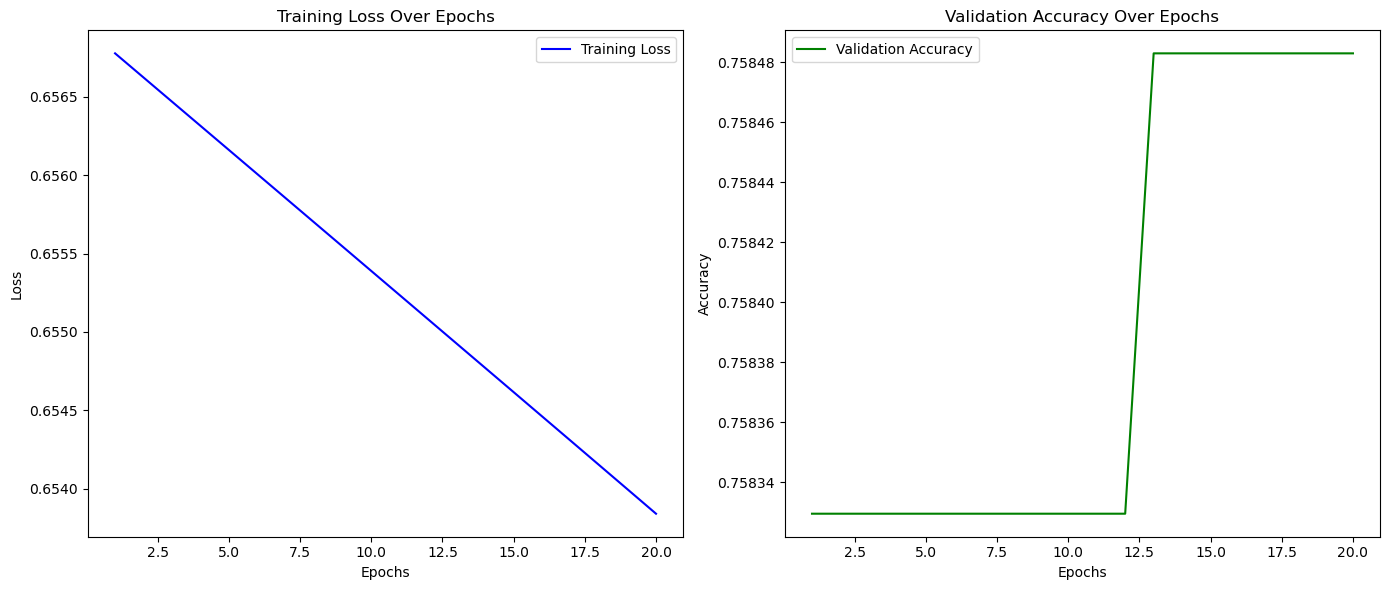

Hybrid Model Accuracy: 0.7588


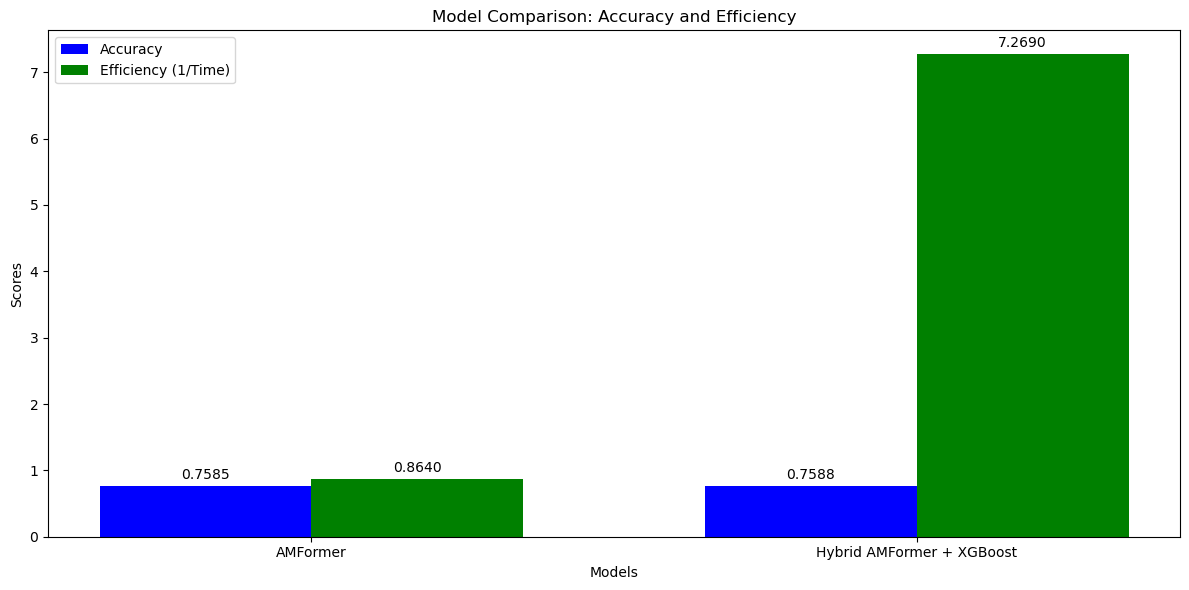

In [5]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Step 1: Load and preprocess the data
def load_data(file_path):
    """Load and preprocess the Adult dataset."""
    data = pd.read_csv(file_path)

    # Encode target variable
    data['income'] = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

    # Encode categorical features
    categorical_features = ['workclass', 'education', 'marital_status', 'occupation',
                            'relationship', 'race', 'sex', 'native_country']
    for col in categorical_features:
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col].astype(str))

    # Separate features and target
    X = data.drop('income', axis=1)
    y = data['income']

    # Normalize numerical features
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)

    return train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define AMFormer with higher-order feature interactions
class AMFormer(nn.Module):
    def __init__(self, input_dim, num_classes=1, interaction_order=3):
        super(AMFormer, self).__init__()
        self.interaction_order = interaction_order
        self.attention_layers = nn.ModuleList([ 
            nn.Linear(input_dim, input_dim) for _ in range(interaction_order) 
        ])
        self.feature_importance_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Softmax(dim=-1)
        )
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        interaction = x
        for layer in self.attention_layers:
            interaction = torch.relu(layer(interaction))  # Handling higher-order interactions
        feature_importance = self.feature_importance_net(x)  # Dynamic feature importance
        weighted_features = x * feature_importance  # Weight features based on importance
        combined = weighted_features + interaction  # Combine weighted features with interactions
        return self.fc(combined)

# Step 3: Training function
def train_model(model, X_train, y_train, X_val, y_val, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    X_train, y_train = torch.tensor(X_train.values).float().to(device), torch.tensor(y_train.values).float().to(device)
    X_val, y_val = torch.tensor(X_val.values).float().to(device), torch.tensor(y_val.values).float().to(device)

    training_losses = []
    validation_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = torch.sigmoid(model(X_val).squeeze())
            val_preds = (val_outputs > 0.5).float()
            val_acc = accuracy_score(y_val.cpu(), val_preds.cpu())
            validation_accuracies.append(val_acc)
            print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, Val Accuracy: {val_acc:.4f}")

    return training_losses, validation_accuracies

# Step 4: Hybrid Model with XGBoost
class HybridModel:
    def __init__(self, amformer, xgb):
        self.amformer = amformer
        self.xgb = xgb

    def train(self, X_train, y_train):
        self.amformer.eval()  # Ensure AMFormer is in evaluation mode
        with torch.no_grad():
            X_transformed = self.amformer(torch.tensor(X_train.values).float()).cpu().numpy()  # Extract features
        self.xgb.fit(X_transformed, y_train)

    def predict(self, X_test):
        self.amformer.eval()  # Ensure AMFormer is in evaluation mode
        with torch.no_grad():
            X_transformed = self.amformer(torch.tensor(X_test.values).float()).cpu().numpy()  # Extract features
        return self.xgb.predict(X_transformed)

# Step 5: Visualization
def plot_metrics(training_losses, validation_accuracies):
    epochs = range(1, len(training_losses) + 1)

    plt.figure(figsize=(14, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_efficiency_and_accuracy(models, accuracies, times):
    x = np.arange(len(models))  # Label locations
    width = 0.35  # Width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width / 2, accuracies, width, label='Accuracy', color='blue')
    bars2 = ax.bar(x + width / 2, 1 / np.array(times), width, label='Efficiency (1/Time)', color='green')

    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison: Accuracy and Efficiency')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Example Workflow
if __name__ == "__main__":
    # Load dataset
    dataset_path = 'adult.csv'  # Use your dataset
    X_train, X_test, y_train, y_test = load_data(dataset_path)

    # Train AMFormer
    amformer = AMFormer(input_dim=X_train.shape[1], num_classes=1, interaction_order=3)
    start_time = time.time()
    training_losses, validation_accuracies = train_model(amformer, X_train, y_train, X_test, y_test, epochs=20)
    amformer_time = time.time() - start_time

    # Plot metrics for AMFormer
    plot_metrics(training_losses, validation_accuracies)

    # Hybrid Model with XGBoost
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    hybrid_model = HybridModel(amformer, xgb_model)
    start_time = time.time()
    hybrid_model.train(X_train, y_train)
    hybrid_time = time.time() - start_time

    hybrid_preds = hybrid_model.predict(X_test)
    hybrid_acc = accuracy_score(y_test, hybrid_preds)
    print(f"Hybrid Model Accuracy: {hybrid_acc:.4f}")

    # Efficiency and accuracy comparison
    models = ["AMFormer", "Hybrid AMFormer + XGBoost"]
    accuracies = [max(validation_accuracies), hybrid_acc]
    times = [amformer_time, hybrid_time]

    plot_efficiency_and_accuracy(models, accuracies, times)


In [18]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")


# Load and preprocess data
def load_data(file_path):
    """Load and preprocess the Adult dataset."""
    data = pd.read_csv(file_path)

    # Encode target variable
    data['income'] = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

    # Encode categorical features
    categorical_features = ['workclass', 'education', 'marital_status', 'occupation',
                            'relationship', 'race', 'sex', 'native_country']
    for col in categorical_features:
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col].astype(str))

    # Separate features and target
    X = data.drop('income', axis=1)
    y = data['income']

    # Normalize numerical features
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)

    return train_test_split(X, y, test_size=0.2, random_state=42)


# Define AMFormer model
class AMFormer(nn.Module):
    def __init__(self, input_dim, num_classes=1, interaction_order=3, dropout_rate=0.3):
        super(AMFormer, self).__init__()
        self.interaction_order = interaction_order
        self.attention_layers = nn.ModuleList([ 
            nn.Linear(input_dim, input_dim) for _ in range(interaction_order) 
        ])
        self.feature_importance_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, input_dim),
            nn.Softmax(dim=-1)
        )
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        interaction = x
        for layer in self.attention_layers:
            interaction = torch.relu(layer(interaction))
        feature_importance = self.feature_importance_net(x)
        weighted_features = x * feature_importance
        combined = weighted_features + interaction
        return self.fc(combined)


# Train function for AMFormer
def train_model(model, X_train, y_train, X_val, y_val, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    X_train, y_train = torch.tensor(X_train.values).float().to(device), torch.tensor(y_train.values).float().to(device)
    X_val, y_val = torch.tensor(X_val.values).float().to(device), torch.tensor(y_val.values).float().to(device)

    training_losses = []
    validation_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = torch.sigmoid(model(X_val).squeeze())
            val_preds = (val_outputs > 0.5).float()
            val_acc = accuracy_score(y_val.cpu(), val_preds.cpu())
            validation_accuracies.append(val_acc)
            print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, Val Accuracy: {val_acc:.4f}")

    return training_losses, validation_accuracies


# Hybrid Model with XGBoost
class HybridModel:
    def __init__(self, amformer, xgb):
        self.amformer = amformer
        self.xgb = xgb

    def train(self, X_train, y_train):
        self.amformer.eval()
        with torch.no_grad():
            X_transformed = self.amformer(torch.tensor(X_train.values).float()).cpu().numpy()
        self.xgb.fit(X_transformed, y_train)

    def predict(self, X_test):
        self.amformer.eval()
        with torch.no_grad():
            X_transformed = self.amformer(torch.tensor(X_test.values).float()).cpu().numpy()
        return self.xgb.predict(X_transformed)





# Example Workflow
if __name__ == "__main__":
    # Load dataset
    dataset_path = 'adult.csv'  # Use your dataset
    X_train, X_test, y_train, y_test = load_data(dataset_path)

    # Train AMFormer
    amformer = AMFormer(input_dim=X_train.shape[1], num_classes=1, interaction_order=3)
    start_time = time.time()
    training_losses, validation_accuracies = train_model(amformer, X_train, y_train, X_test, y_test, epochs=20)
    amformer_time = time.time() - start_time

    # Hybrid Model with XGBoost
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=6)
    hybrid_model = HybridModel(amformer, xgb_model)
    start_time = time.time()
    hybrid_model.train(X_train, y_train)
    hybrid_time = time.time() - start_time

    # Predict and visualize results
    #predict_and_visualize(hybrid_model, X_test, y_test)


Epoch 1, Loss: 0.8162, Val Accuracy: 0.2412
Epoch 2, Loss: 0.8159, Val Accuracy: 0.2412
Epoch 3, Loss: 0.8156, Val Accuracy: 0.2412
Epoch 4, Loss: 0.8153, Val Accuracy: 0.2412
Epoch 5, Loss: 0.8149, Val Accuracy: 0.2412
Epoch 6, Loss: 0.8147, Val Accuracy: 0.2412
Epoch 7, Loss: 0.8143, Val Accuracy: 0.2412
Epoch 8, Loss: 0.8140, Val Accuracy: 0.2412
Epoch 9, Loss: 0.8137, Val Accuracy: 0.2412
Epoch 10, Loss: 0.8134, Val Accuracy: 0.2412
Epoch 11, Loss: 0.8130, Val Accuracy: 0.2412
Epoch 12, Loss: 0.8128, Val Accuracy: 0.2412
Epoch 13, Loss: 0.8124, Val Accuracy: 0.2412
Epoch 14, Loss: 0.8121, Val Accuracy: 0.2412
Epoch 15, Loss: 0.8118, Val Accuracy: 0.2412
Epoch 16, Loss: 0.8115, Val Accuracy: 0.2412
Epoch 17, Loss: 0.8112, Val Accuracy: 0.2412
Epoch 18, Loss: 0.8109, Val Accuracy: 0.2412
Epoch 19, Loss: 0.8105, Val Accuracy: 0.2412
Epoch 20, Loss: 0.8102, Val Accuracy: 0.2412


Epoch 1, Loss: 0.6920, Val Accuracy: 0.4769
Epoch 2, Loss: 0.6917, Val Accuracy: 0.4806
Epoch 3, Loss: 0.6914, Val Accuracy: 0.4863
Epoch 4, Loss: 0.6910, Val Accuracy: 0.4919
Epoch 5, Loss: 0.6908, Val Accuracy: 0.4975
Epoch 6, Loss: 0.6905, Val Accuracy: 0.5039
Epoch 7, Loss: 0.6902, Val Accuracy: 0.5090
Epoch 8, Loss: 0.6899, Val Accuracy: 0.5145
Epoch 9, Loss: 0.6896, Val Accuracy: 0.5188
Epoch 10, Loss: 0.6894, Val Accuracy: 0.5234
Epoch 11, Loss: 0.6891, Val Accuracy: 0.5288
Epoch 12, Loss: 0.6888, Val Accuracy: 0.5332
Epoch 13, Loss: 0.6885, Val Accuracy: 0.5391
Epoch 14, Loss: 0.6882, Val Accuracy: 0.5428
Epoch 15, Loss: 0.6879, Val Accuracy: 0.5469
Epoch 16, Loss: 0.6877, Val Accuracy: 0.5520
Epoch 17, Loss: 0.6874, Val Accuracy: 0.5570
Epoch 18, Loss: 0.6871, Val Accuracy: 0.5638
Epoch 19, Loss: 0.6868, Val Accuracy: 0.5692
Epoch 20, Loss: 0.6865, Val Accuracy: 0.5738
Analyzing Feature Interactions for Sample:
           age  workclass    fnlwgt  education  education_num  mar

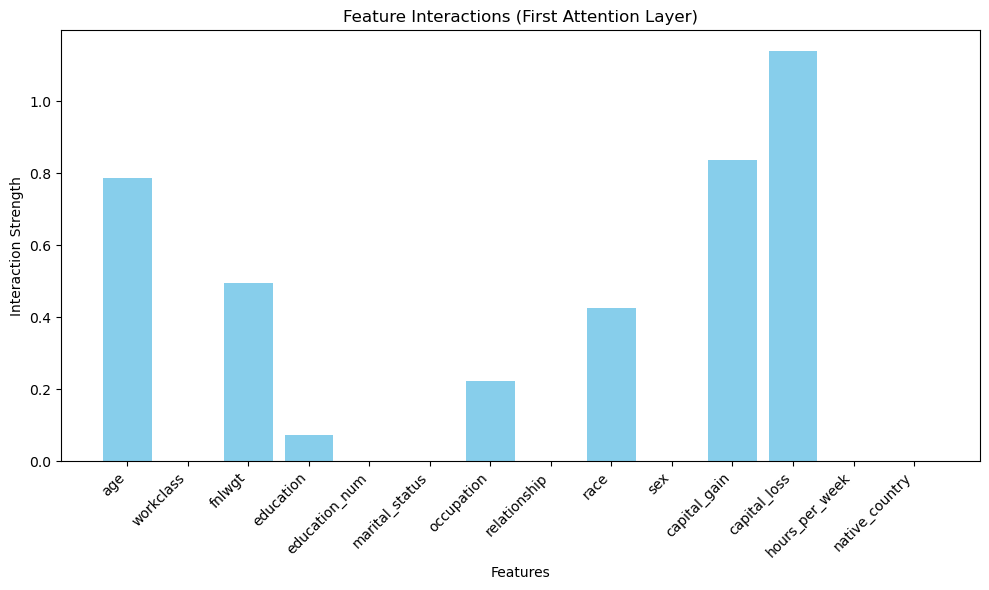

Significant Feature Interactions:
age: 0.7861
fnlwgt: 0.4947
occupation: 0.2231
race: 0.4257
capital_gain: 0.8351
capital_loss: 1.1392


In [9]:
# Visualize feature interactions
def visualize_feature_interaction(model, sample_input, feature_names):
    """
    Visualize feature interactions from the AMFormer model.
    
    Parameters:
        model: Trained AMFormer model.
        sample_input: A single sample input as a pandas DataFrame.
        feature_names: List of feature names.
    """
    model.eval()
    with torch.no_grad():
        # Convert sample input to tensor
        sample_input_tensor = torch.tensor(sample_input.values).float()

        # Extract interactions from the first attention layer
        interaction = sample_input_tensor
        for i, layer in enumerate(model.attention_layers):
            interaction = torch.relu(layer(interaction))
            if i == 0:  # Visualize interactions after the first attention layer
                interaction_values = interaction.squeeze().numpy()
                break

    # Plot feature interaction values
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, interaction_values, color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Interaction Strength')
    plt.title('Feature Interactions (First Attention Layer)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Highlight significant interactions
    significant_interactions = {
        feature: value for feature, value in zip(feature_names, interaction_values) if abs(value) > 0.1
    }
    print("Significant Feature Interactions:")
    for feature, value in significant_interactions.items():
        print(f"{feature}: {value:.4f}")


# Example Workflow: Add this to the existing script
if __name__ == "__main__":
    # Load dataset
    dataset_path = 'adult.csv'  # Use your dataset
    X_train, X_test, y_train, y_test = load_data(dataset_path)

    # Train AMFormer
    amformer = AMFormer(input_dim=X_train.shape[1], num_classes=1, interaction_order=3)
    training_losses, validation_accuracies = train_model(amformer, X_train, y_train, X_test, y_test, epochs=20)

    # Visualize Feature Interactions
    sample_idx = 0  # Index of the sample to analyze
    sample_input = X_test.iloc[[sample_idx]]
    feature_names = X_test.columns.tolist()
    print("Analyzing Feature Interactions for Sample:")
    print(sample_input)
    visualize_feature_interaction(amformer, sample_input, feature_names)


In [10]:
if __name__ == "__main__":
    # Step 1: Load dataset
    dataset_path = 'adult.csv'  # Replace this with the actual path to your dataset
    X_train, X_test, y_train, y_test = load_data(dataset_path)

    # Step 2: Train AMFormer
    print("Training AMFormer...")
    amformer = AMFormer(input_dim=X_train.shape[1], num_classes=1, interaction_order=3)
    start_time = time.time()
    training_losses, validation_accuracies = train_model(amformer, X_train, y_train, X_test, y_test, epochs=20)
    amformer_time = time.time() - start_time
    print(f"AMFormer training completed in {amformer_time:.2f} seconds.")

    # Step 3: Train Hybrid Model (AMFormer + XGBoost)
    print("\nTraining Hybrid Model...")
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, max_depth=6)
    hybrid_model = HybridModel(amformer, xgb_model)
    start_time = time.time()
    hybrid_model.train(X_train, y_train)
    hybrid_time = time.time() - start_time
    print(f"Hybrid model training completed in {hybrid_time:.2f} seconds.")

    # Step 4: Evaluate Models
    print("\nEvaluating Models...")
    with torch.no_grad():
        amformer.eval()
        amformer_preds = torch.sigmoid(amformer(torch.tensor(X_test.values).float())).squeeze()
        amformer_preds = (amformer_preds > 0.5).float().cpu().numpy()
        amformer_acc = accuracy_score(y_test, amformer_preds)
        amformer_auc = roc_auc_score(y_test, amformer_preds)

    hybrid_preds = hybrid_model.predict(X_test)
    hybrid_acc = accuracy_score(y_test, hybrid_preds)
    hybrid_auc = roc_auc_score(y_test, hybrid_preds)

    print(f"\nAMFormer Performance:\n  - Accuracy: {amformer_acc:.4f}\n  - AUC: {amformer_auc:.4f}")
    print(f"Hybrid Model Performance:\n  - Accuracy: {hybrid_acc:.4f}\n  - AUC: {hybrid_auc:.4f}")

    # Step 5: Test Prediction Example
    print("\nExample Prediction:")
    example_data = X_test.iloc[:1]  # Take the first row of the test set as an example
    print(f"Input Data:\n{example_data}")

    amformer.eval()
    with torch.no_grad():
        example_output = torch.sigmoid(amformer(torch.tensor(example_data.values).float())).squeeze().item()
    print(f"AMFormer Prediction: {example_output:.4f} (Probability of income >50K)")

    hybrid_pred = hybrid_model.predict(example_data)
    print(f"Hybrid Model Prediction: {hybrid_pred[0]} (Class label)")


Training AMFormer...
Epoch 1, Loss: 0.7005, Val Accuracy: 0.3605
Epoch 2, Loss: 0.7002, Val Accuracy: 0.3636
Epoch 3, Loss: 0.7000, Val Accuracy: 0.3690
Epoch 4, Loss: 0.6998, Val Accuracy: 0.3731
Epoch 5, Loss: 0.6997, Val Accuracy: 0.3772
Epoch 6, Loss: 0.6994, Val Accuracy: 0.3799
Epoch 7, Loss: 0.6992, Val Accuracy: 0.3825
Epoch 8, Loss: 0.6990, Val Accuracy: 0.3868
Epoch 9, Loss: 0.6988, Val Accuracy: 0.3912
Epoch 10, Loss: 0.6986, Val Accuracy: 0.3957
Epoch 11, Loss: 0.6984, Val Accuracy: 0.4014
Epoch 12, Loss: 0.6982, Val Accuracy: 0.4072
Epoch 13, Loss: 0.6980, Val Accuracy: 0.4133
Epoch 14, Loss: 0.6978, Val Accuracy: 0.4162
Epoch 15, Loss: 0.6976, Val Accuracy: 0.4199
Epoch 16, Loss: 0.6974, Val Accuracy: 0.4236
Epoch 17, Loss: 0.6972, Val Accuracy: 0.4262
Epoch 18, Loss: 0.6970, Val Accuracy: 0.4301
Epoch 19, Loss: 0.6968, Val Accuracy: 0.4345
Epoch 20, Loss: 0.6966, Val Accuracy: 0.4390
AMFormer training completed in 1.27 seconds.

Training Hybrid Model...
Hybrid model trai